In [18]:
%load_ext autoreload
%autoreload 2

import warnings
import time
import os 
warnings.filterwarnings('ignore') 

from matplotlib import pyplot as plt 
from IPython.display import clear_output

from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern, RBF
from sklearn.preprocessing import MinMaxScaler
import numpy as np

os.chdir("/Users/satya/Documents/sklearn-bax/")
plt.style.use("mpl_style/matplotlib.rc")

from src.utils import XY_from_csv, random_sampling_no_replace
from src.acquisition import multiproperty_infobax, multiproperty_meanbax, mixed, get_next_id
from src.algorithms import MultiRegionSetUnion, MultiRegionSetIntersection, GlobalOptimization1D, ParetoFront, Wishlist
from src.models import MGPR



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
X, Y = XY_from_csv("datasets/ssrl_ternary.csv", columns_x=["c_Fe","c_Co"], columns_y=["coer", "kerr"])


x_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scalers = [x_scaler, y_scaler]

X = x_scaler.fit_transform(X)
Y = y_scaler.fit_transform(Y)


if len(Y.shape) == 1:
    Y = Y.reshape(-1, 1)

In [20]:
# algorithm = MultiRegionSetIntersection(threshold_list = [[3.5, 4.0], [0.3, 0.4]], scalers = scalers)

algorithm = Wishlist(threshold_bounds = [[[0.0, 2.0], [0.0, 0.2]], [[3.0, 4.0], [0.3, 0.4]], [[8.0, 10.0], [0.0, 0.1]]], scalers = scalers)

# algorithm = ParetoFront(tolerance_list = [0.05, 0.01],  max_or_min_list = [1, 1], scalers = scalers)
true_target_ids = algorithm.identify_subspace(x=X, y=Y)

In [21]:
def fit_hypers(x_train, y_train, kernel_list, n_restarts_optimizer = 30):
    multi_gpr = MGPR(kernel_list=kernel_list, n_restarts_optimizer = n_restarts_optimizer)
    multi_gpr.fit(x_train, y_train)
    
    n_models = len(multi_gpr.models)
    kernels = [] 

    for i in range(n_models):
        params = multi_gpr.models[i].kernel_.get_params()
        alpha = params['k1__k1__constant_value']
        ls = params['k1__k2__length_scale']
        noise = params['k2__noise_level']
        k = ConstantKernel(constant_value = alpha, constant_value_bounds='fixed') * Matern(nu = 5/2, length_scale= ls, length_scale_bounds='fixed') + WhiteKernel(noise, noise_level_bounds='fixed')
        kernels.append(k)

    return kernels

  0%|          | 0/301 [00:00<?, ?it/s]

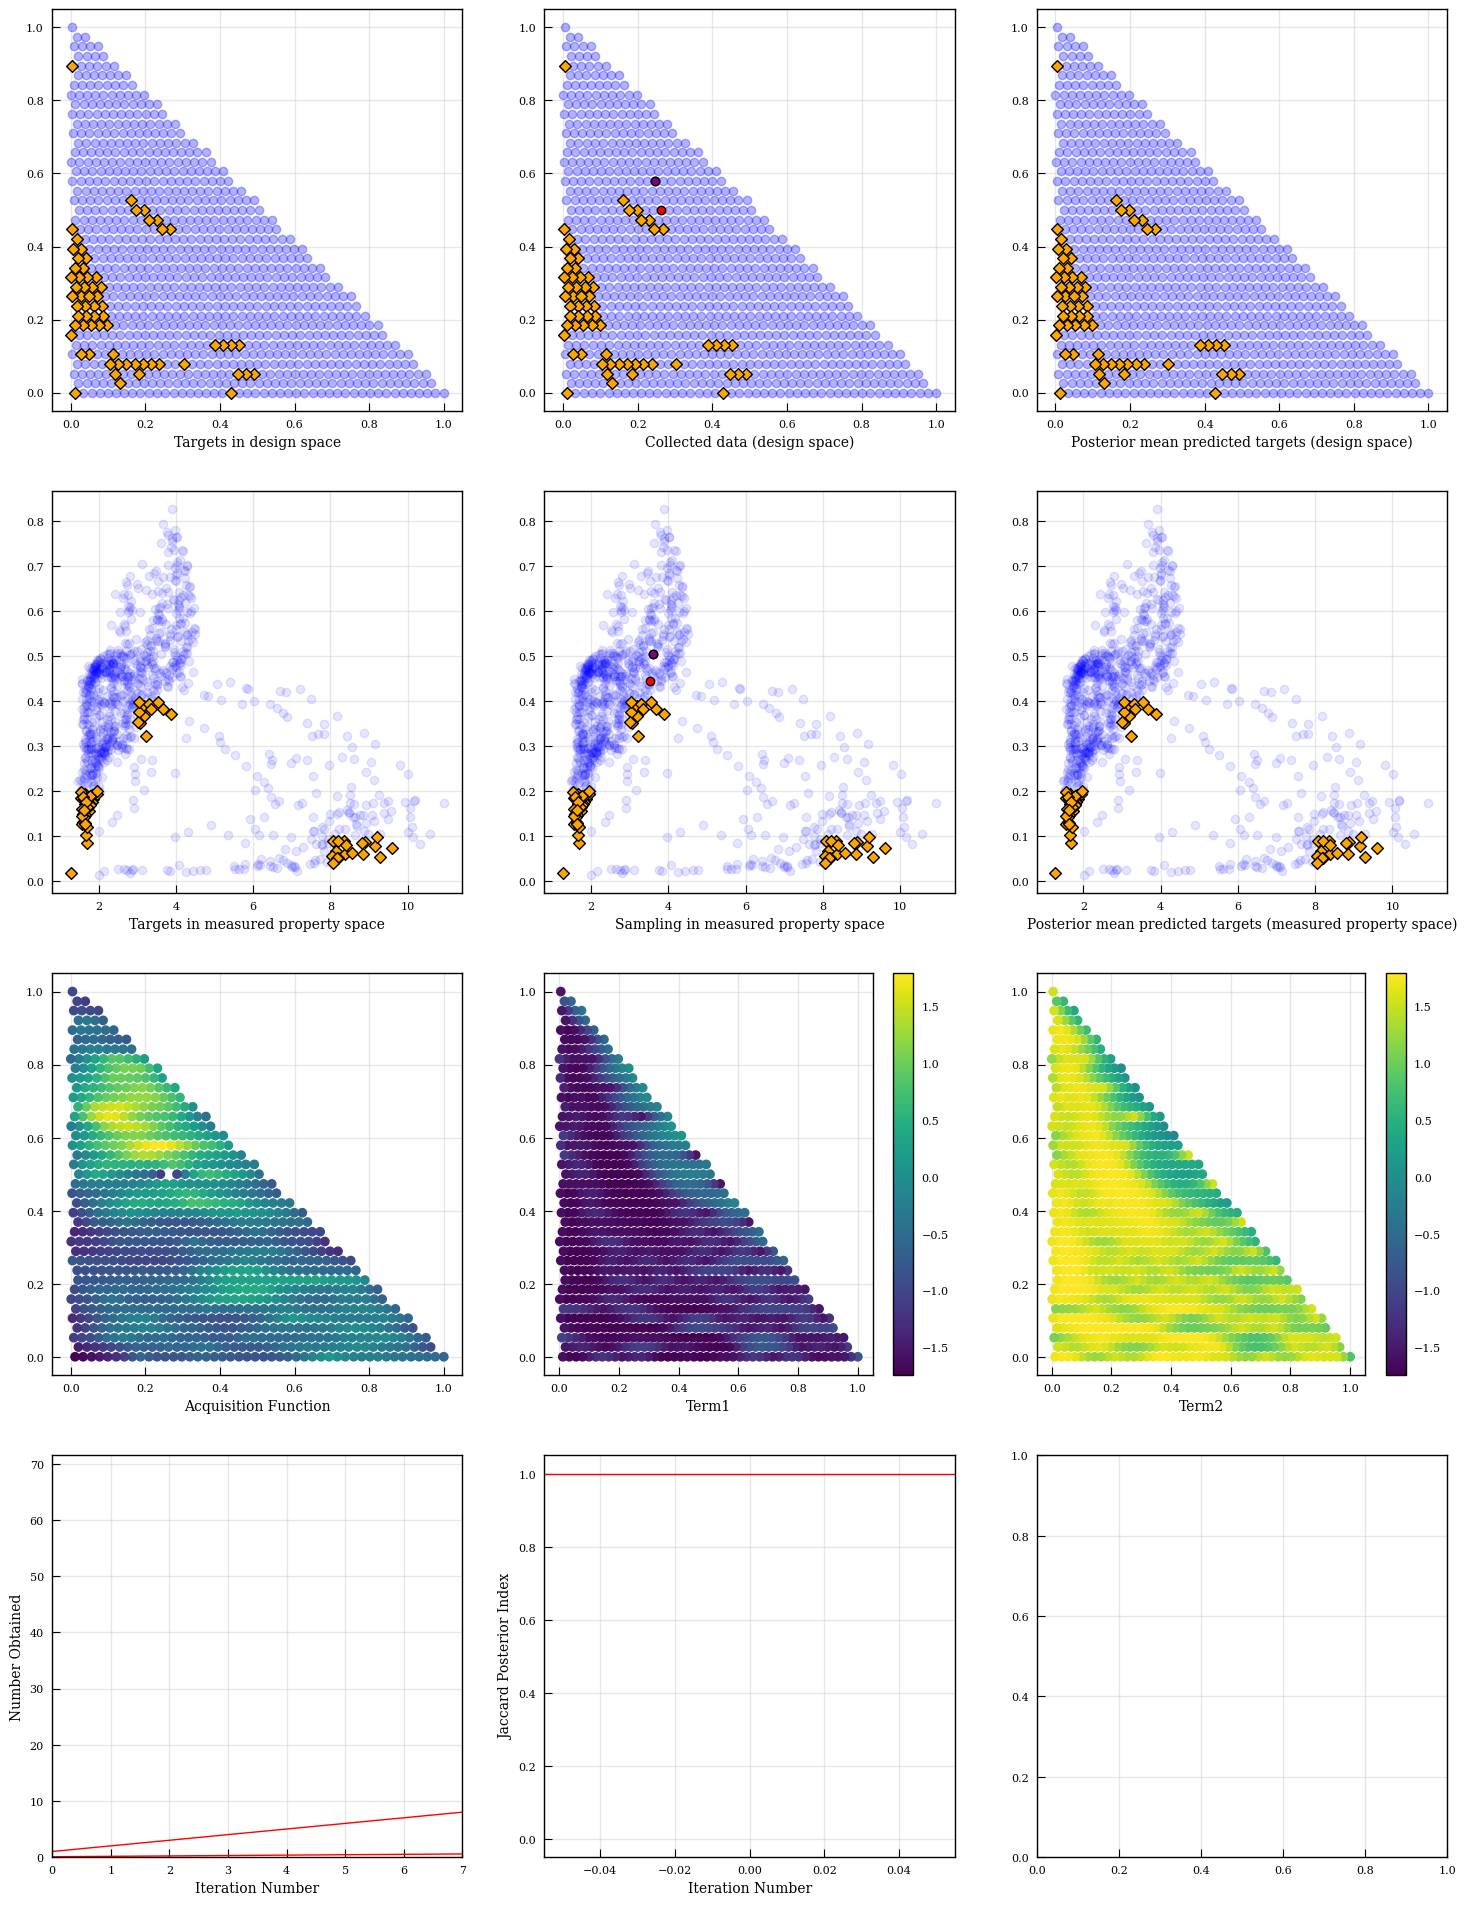

 33%|███▎      | 100/301 [00:16<00:50,  3.97it/s]

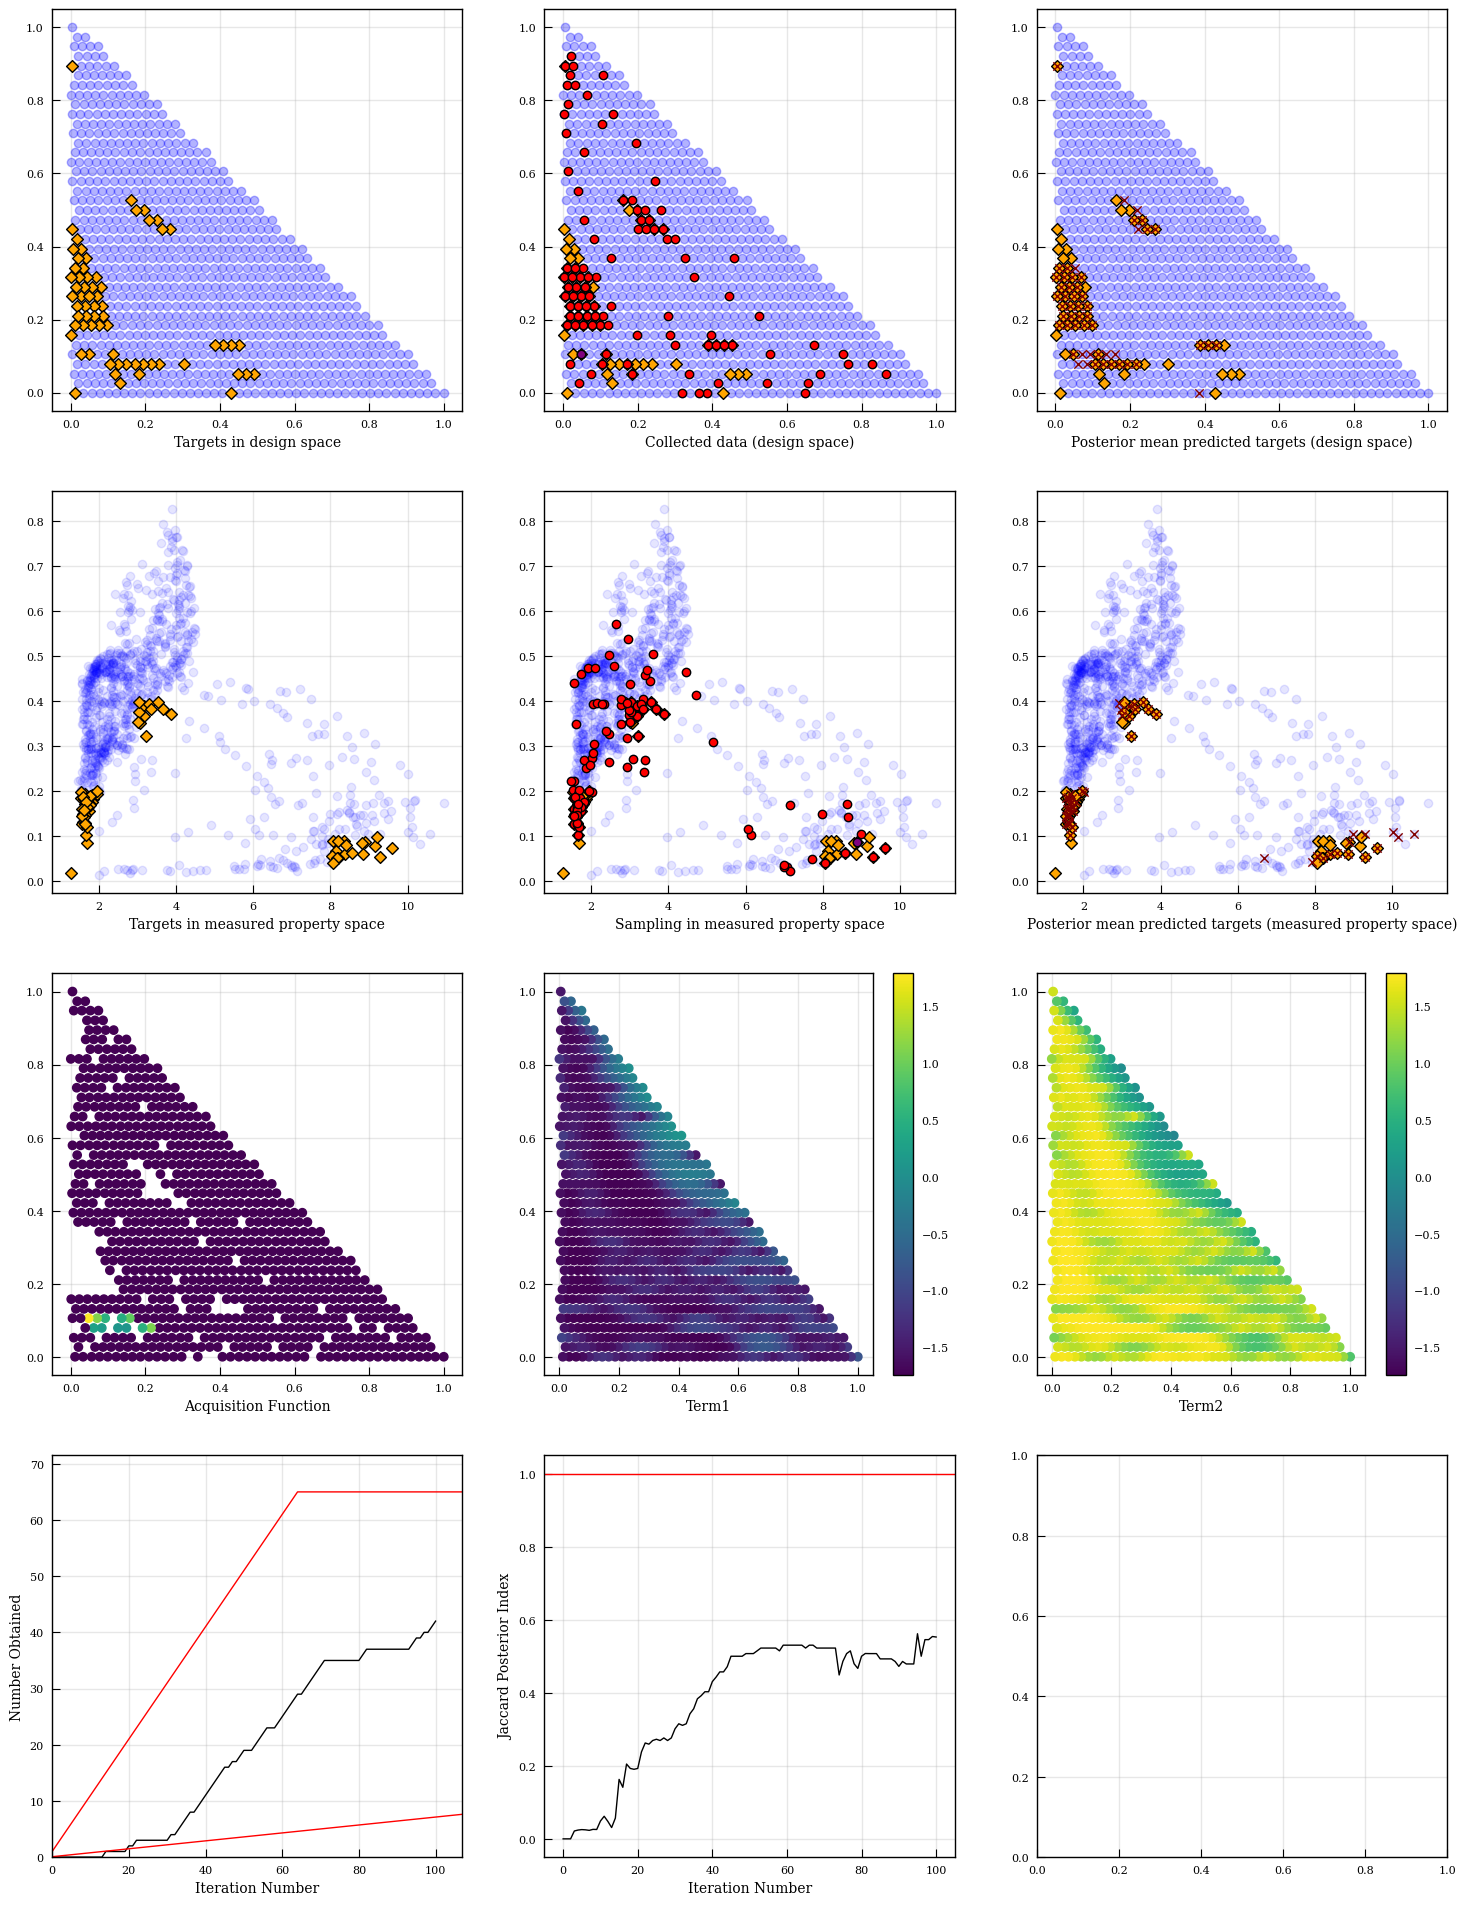

 66%|██████▋   | 200/301 [01:58<02:18,  1.37s/it]

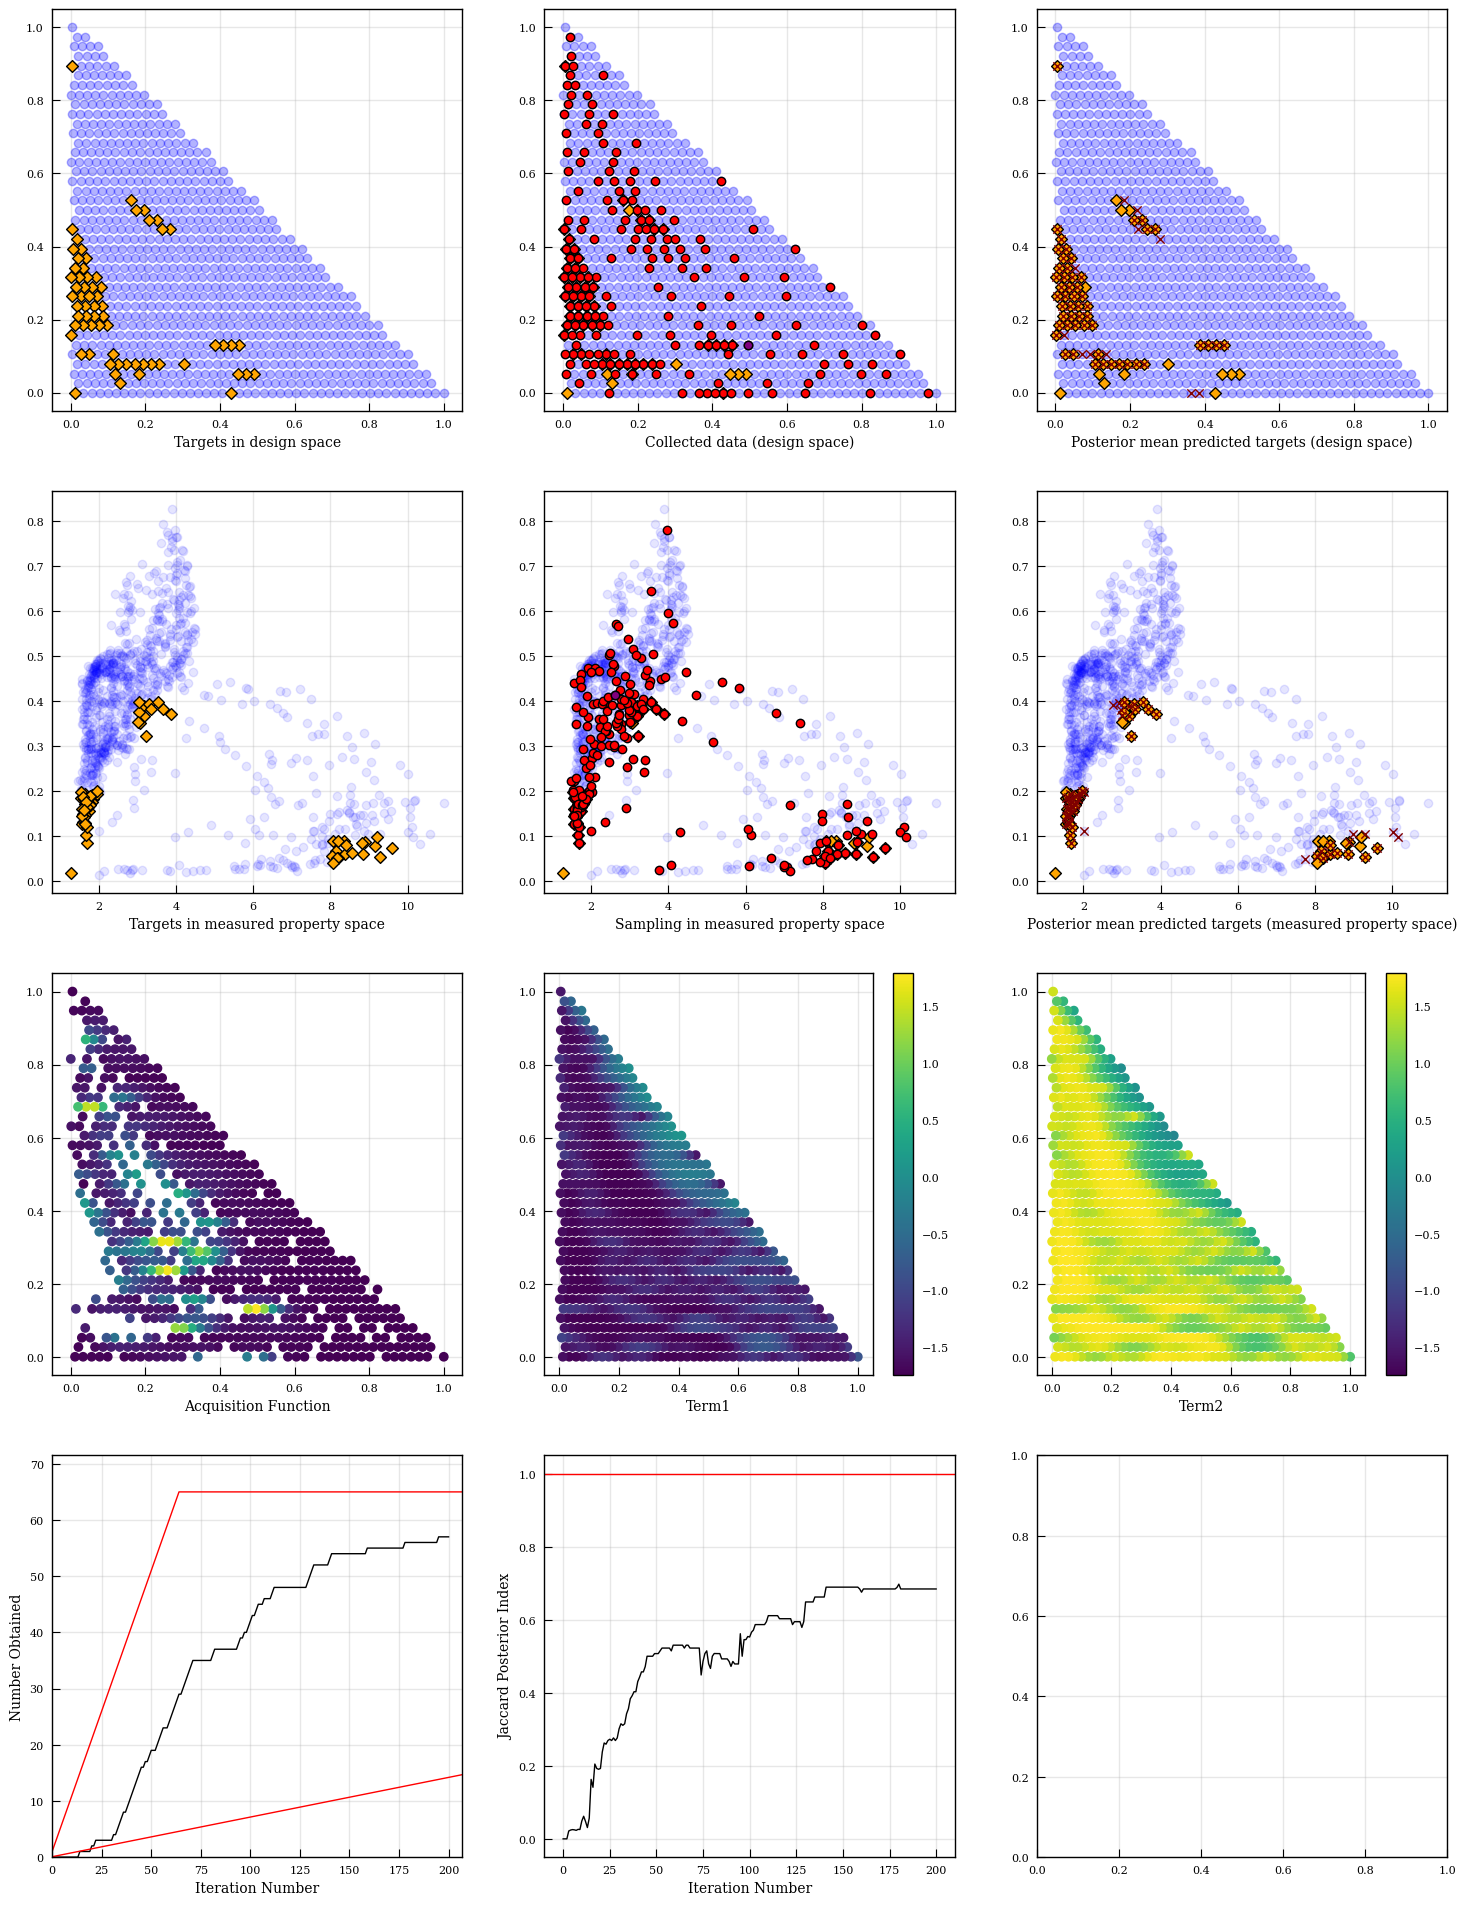

100%|█████████▉| 300/301 [04:46<00:02,  2.03s/it]

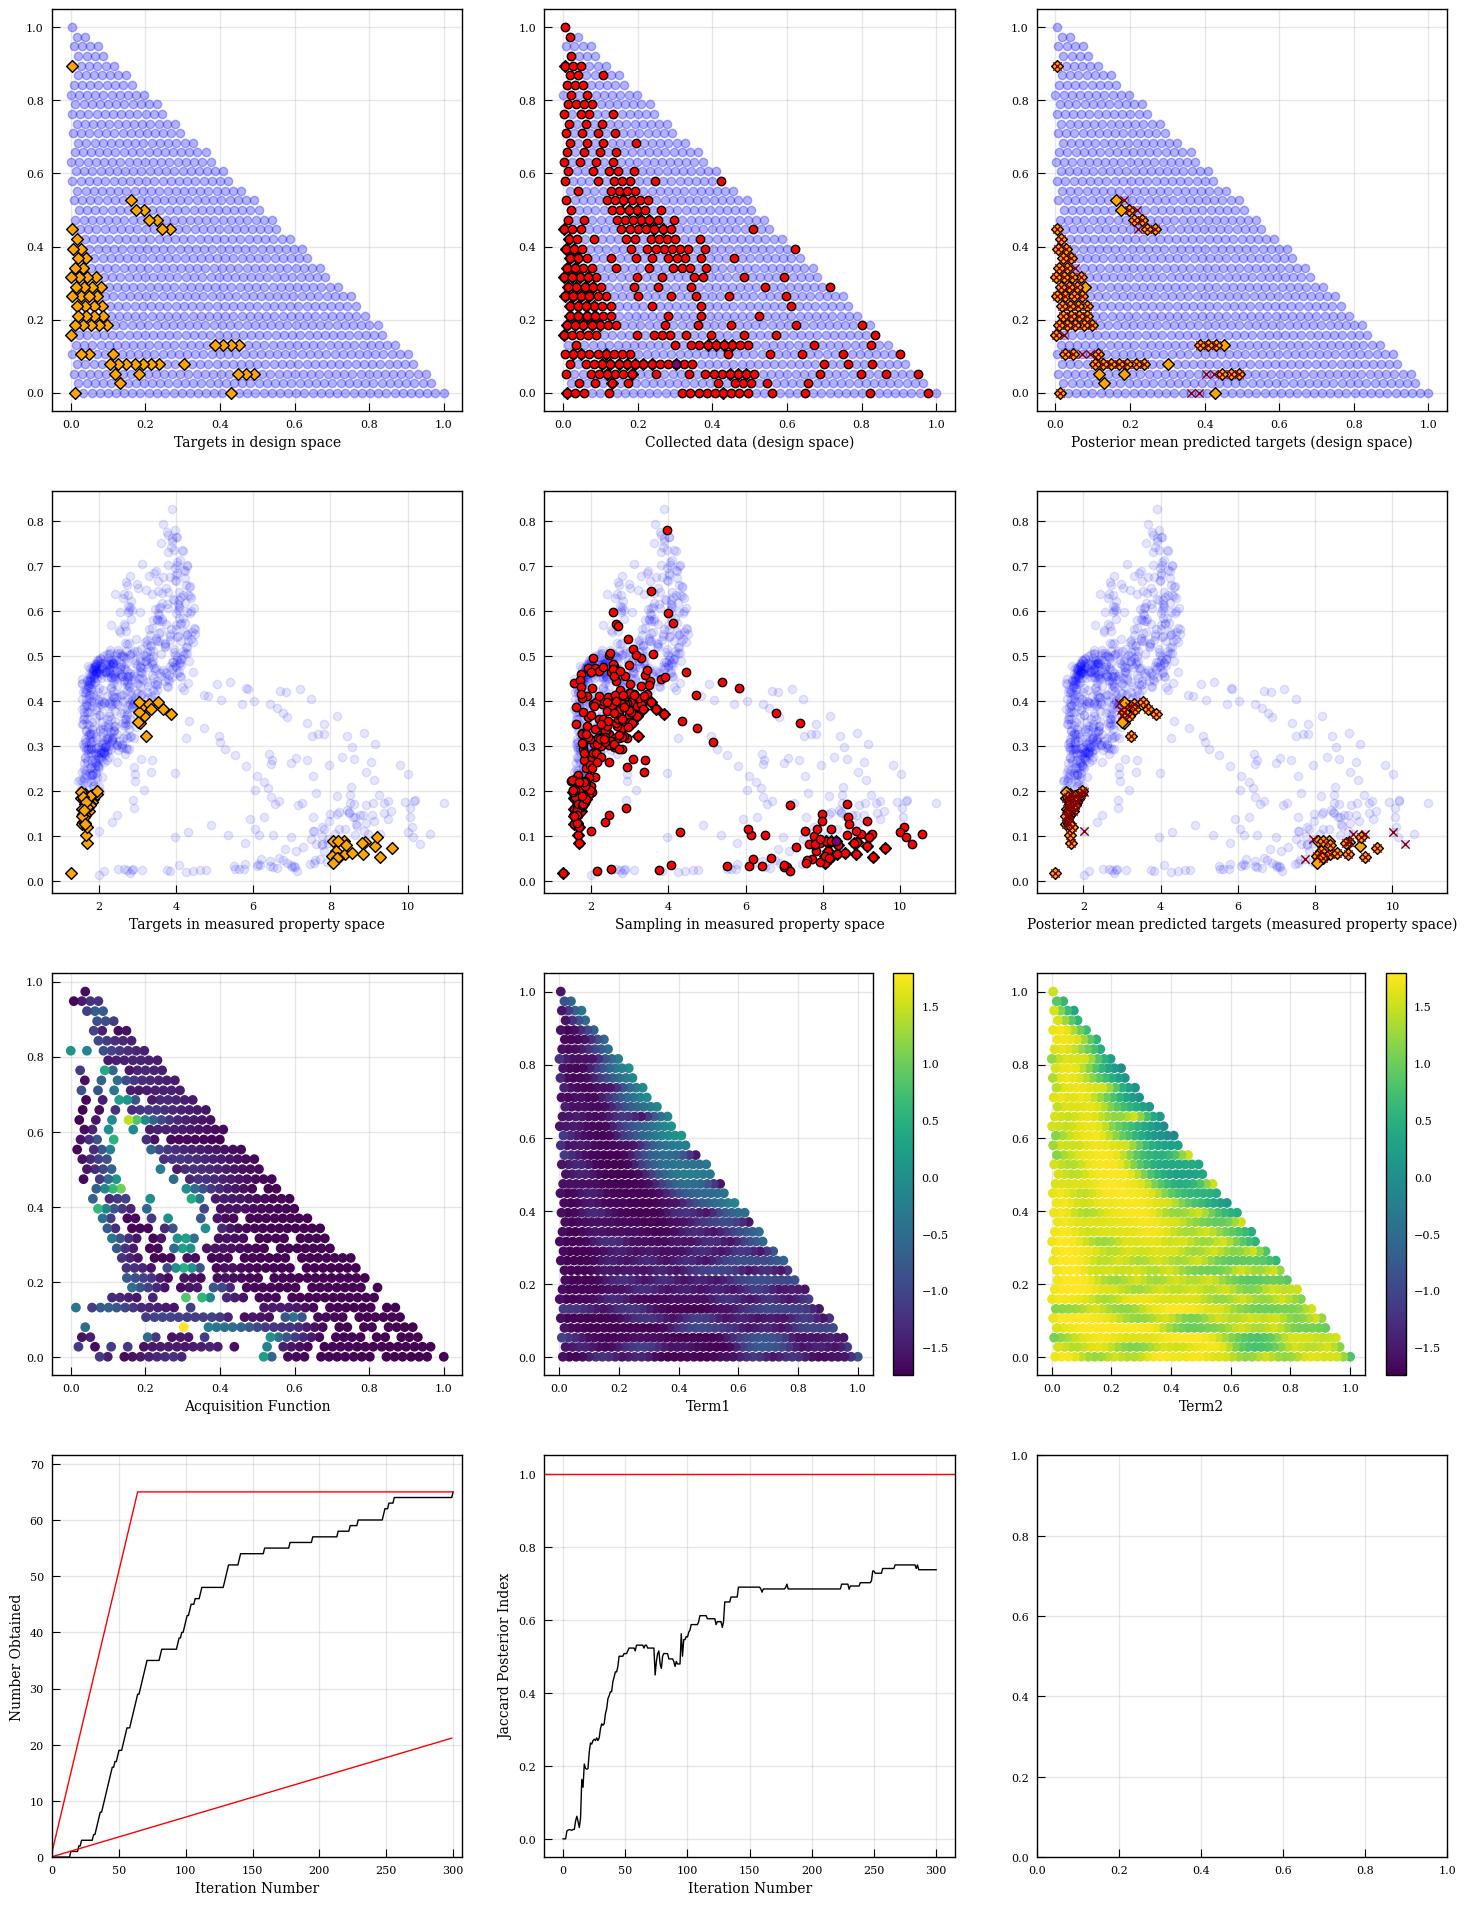

100%|██████████| 301/301 [04:50<00:00,  1.04it/s]


KeyError: 'mixed'

In [22]:
from tqdm import tqdm 

metrics = {"mixed": {"n_obtained": [], "jaccard_posterior_index": []},
           "meanbax": {"n_obtained": [], "jaccard_posterior_index": []},
           "infobax": {"n_obtained": [], "jaccard_posterior_index": []}}

all_ids = list(np.arange(0, len(X)))
true_target_ids = algorithm.identify_subspace(x=X, y=Y)
true_not_target_ids = list(set(all_ids) - set(true_target_ids))

plotting = True
prevent_requery = True 
plot_frequency = 100
n_posterior_samples = 20
n_initial = 1 
n_iters = 301
n_repeats = 1
fixed_hypers = True
adaptive_fit_freq = 10 

# kernel_initial = ConstantKernel(constant_value = 1.0, constant_value_bounds=[0.01, 2.0]) * Matern(nu = 5/2, length_scale=[0.5, 0.5], length_scale_bounds= 2 * [[0.01, 2.0]]) + WhiteKernel(noise_level=0.01, noise_level_bounds = [0.0001, 0.1])
# kernel_initial_list=[kernel_initial, kernel_initial]

# if fixed_hypers:
#     kernel_list = fit_hypers(x_train=X, y_train=Y, kernel_list=kernel_initial_list)

strategies = ['mixed', 'infobax', 'meanbax']

for strategy in strategies:
    for j in range(n_repeats):
        np.random.seed(j)

        train_indices = list(np.random.choice(all_ids, n_initial))    
        x_train = X[train_indices]
        y_train = Y[train_indices]
        n_features = X.shape[1]
        
        # assert len(kernel_list) == y_train.shape[1]

        collected_ids = list(train_indices)
        n_obtained = [] 
        jaccard_posterior = [] 

        # baselines 
        random_sampling = [random_sampling_no_replace(len(X), len(true_target_ids), n) for n in range(n_initial, n_iters)]

        if n_iters <= len(true_target_ids):
            best_possible_n_obtained = np.arange(n_initial, n_iters + n_initial)
        else:
            best_possible_n_obtained = list(np.arange(n_initial,len(true_target_ids))) + list(len(true_target_ids)*np.ones(n_iters + n_initial - len(true_target_ids)))

        for i in tqdm(range(n_iters)):
            if (i % adaptive_fit_freq == 0) and (fixed_hypers == False):
                kernel_list = fit_hypers(x_train=x_train, y_train=y_train, kernel_list=kernel_initial_list)

            multi_gpr = MGPR(kernel_list=kernel_list)
            if strategy == 'infobax':
                acquisition_function, multi_gpr, term1, term2 = multiproperty_infobax(x_domain = X, x_train = x_train, y_train = y_train, model = multi_gpr, algorithm = algorithm, n_posterior_samples=n_posterior_samples, verbose=False)
            elif strategy == 'meanbax':
                acquisition_function, multi_gpr = multiproperty_meanbax(x_domain = X, x_train = x_train, y_train = y_train, model = multi_gpr, algorithm = algorithm, collected_ids = collected_ids)
            elif strategy == 'mixed':
                acquisition_function, multi_gpr = mixed(x_domain = X, x_train = x_train, y_train = y_train, model= multi_gpr, algorithm = algorithm, n_posterior_samples = n_posterior_samples, collected_ids = collected_ids)
            else:
                break
            vmax = np.max([np.max(term1), np.max(term2)])
            vmin = np.min([np.min(term1), np.min(term2)])
            
            next_id = get_next_id(acquisition_function=acquisition_function, collected_ids=collected_ids, prevent_requery=True)

            collected_ids.append(next_id)
            n_obtained.append(len(set(collected_ids).intersection(set(true_target_ids))))

            posterior_mean, posterior_std = multi_gpr.predict(X)
            predicted_target_ids = algorithm.identify_subspace(x=X, y=posterior_mean)

            jaccard = len(set(predicted_target_ids).intersection(set(true_target_ids)))/len(set(predicted_target_ids).union(set(true_target_ids)))
            jaccard_posterior.append(jaccard)

            if (i % plot_frequency == 0) and (plotting):
                fig, axes = plt.subplots(4, 3, dpi=100, figsize=(18, 24))
                axes[0,0].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
                axes[0,0].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
                axes[0,0].set_xlabel('Targets in design space')

                axes[0,1].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
                axes[0,1].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
                axes[0,1].scatter(X[collected_ids, 0], X[collected_ids, 1], color='red', edgecolor='k')
                axes[0,1].scatter(X[collected_ids, 0][-1], X[collected_ids, 1][-1], color='purple', edgecolor='k')
                axes[0,1].set_xlabel('Collected data (design space)')

                axes[0,2].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
                axes[0,2].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
                axes[0,2].scatter(X[predicted_target_ids, 0], X[predicted_target_ids, 1], color='maroon', marker = 'x')
                axes[0,2].set_xlabel('Posterior mean predicted targets (design space)')

                if Y.shape[1] > 1:
                    Y_norm = y_scaler.inverse_transform(Y)
                    axes[1,0].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
                    axes[1,0].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
                    axes[1,0].set_xlabel('Targets in measured property space')
            
                    axes[1,1].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
                    axes[1,1].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
                    axes[1,1].scatter(Y_norm[collected_ids, 0], Y_norm[collected_ids, 1], color='red', edgecolor='k')
                    axes[1,1].scatter(Y_norm[collected_ids, 0][-1], Y_norm[collected_ids, 1][-1], color='purple', edgecolor='k')
                    axes[1,1].set_xlabel('Sampling in measured property space')

                    axes[1,2].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
                    axes[1,2].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
                    axes[1,2].scatter(Y_norm[predicted_target_ids, 0], Y_norm[predicted_target_ids, 1], color='maroon', marker ='x')
                    axes[1,2].set_xlabel('Posterior mean predicted targets (measured property space)')
                else:
                    pass


                axes[2,0].scatter(X[:, 0], X[:, 1], c=acquisition_function)
                axes[2,0].set_xlabel('Acquisition Function')

                t1 = axes[2,1].scatter(X[:, 0], X[:, 1], c=term1, vmin=vmin, vmax=vmax)
                axes[2,1].set_xlabel('Term1')
                fig.colorbar(t1, ax=axes[2,1])

                t2 = axes[2,2].scatter(X[:, 0], X[:, 1], c=term2, vmin=vmin, vmax=vmax)
                axes[2,2].set_xlabel('Term2')
                fig.colorbar(t2, ax=axes[2,2])

                try:
                    axes[3,0].plot(np.arange(0, len(n_obtained)), n_obtained, color='k')
                    axes[3,0].plot(best_possible_n_obtained, color='r')
                    axes[3,0].plot(random_sampling, color='r')
                    axes[3,0].set_xlabel('Iteration Number')
                    axes[3,0].set_ylabel('Number Obtained')
                    axes[3,0].set_ylim(0, 1.1 * len(true_target_ids))
                    axes[3,0].set_xlim(0, len(collected_ids) + 5)
                except:
                    pass
                
                try:
                    axes[3,1].axhline(y=1.0, color='r', linestyle='-')
                    axes[3,1].plot(np.arange(0, len(jaccard_posterior)), jaccard_posterior, color='k')
                    axes[3,1].set_xlabel('Iteration Number')
                    axes[3,1].set_ylabel('Jaccard Posterior Index')
                except:
                    pass
                plt.show()


            x_next = X[next_id]
            y_next = Y[next_id]

            x_train = np.vstack((x_train, x_next))
            y_train = np.vstack((y_train, y_next))

        metrics[strategy]['n_obtained'].append(n_obtained)
        metrics[strategy]['jaccard_posterior_index'].append(jaccard_posterior)


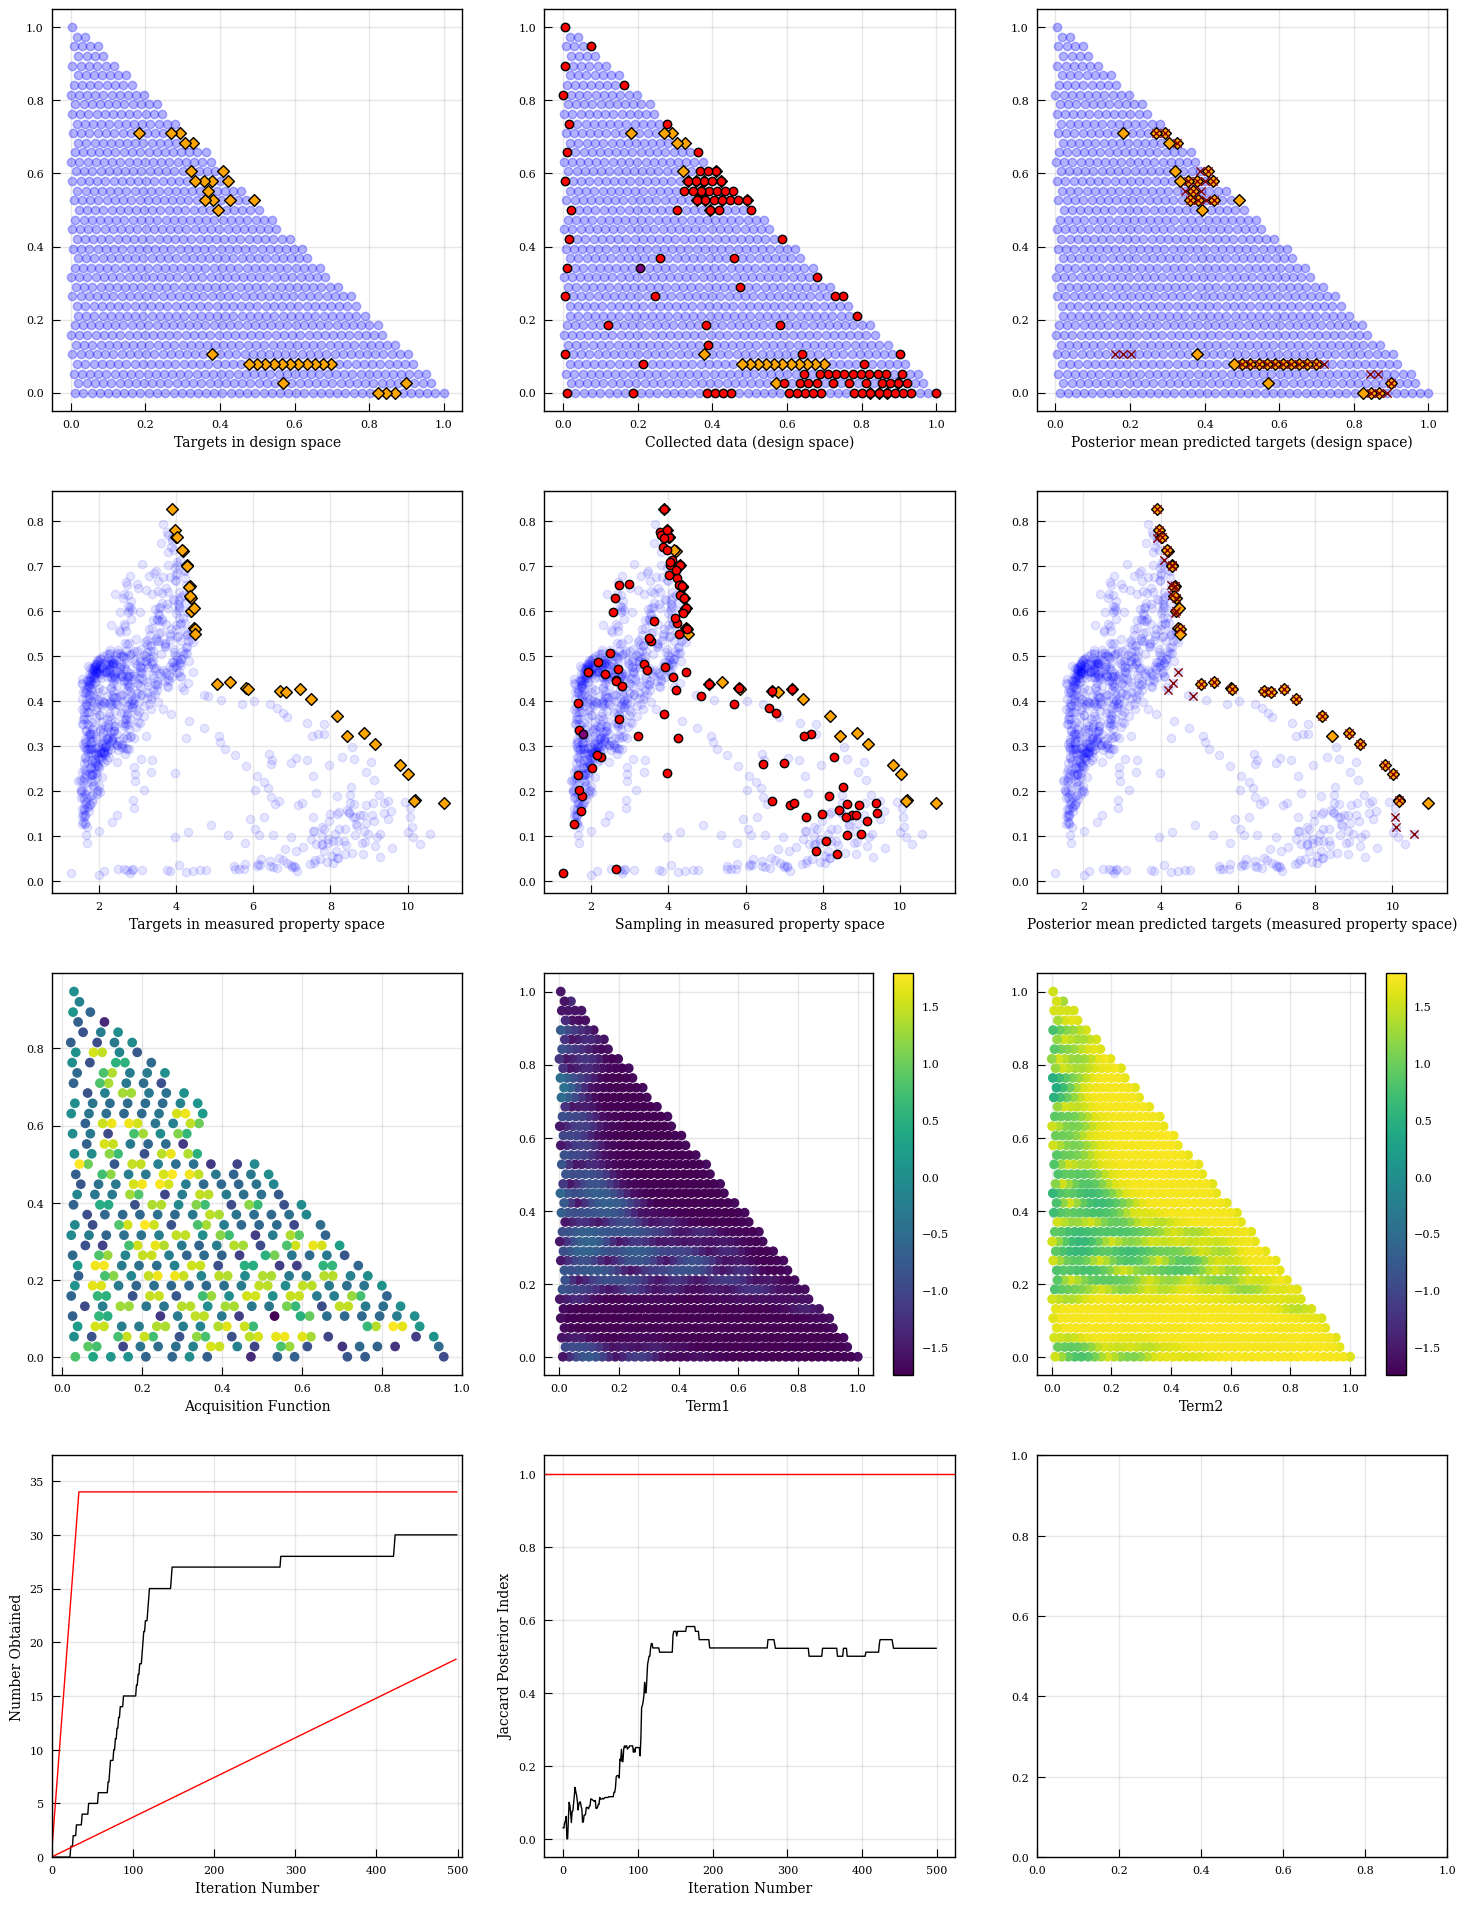

In [20]:
ids_max = 100

fig, axes = plt.subplots(4, 3, dpi=100, figsize=(18, 24))
axes[0,0].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
axes[0,0].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
axes[0,0].set_xlabel('Targets in design space')

axes[0,1].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
axes[0,1].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
axes[0,1].scatter(X[collected_ids, 0][0:ids_max], X[collected_ids, 1][0:ids_max], color='red', edgecolor='k')
axes[0,1].scatter(X[collected_ids, 0][-1], X[collected_ids, 1][-1], color='purple', edgecolor='k')
axes[0,1].set_xlabel('Collected data (design space)')

axes[0,2].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
axes[0,2].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
axes[0,2].scatter(X[predicted_target_ids, 0][0:ids_max], X[predicted_target_ids, 1][0:ids_max], color='maroon', marker = 'x')
axes[0,2].set_xlabel('Posterior mean predicted targets (design space)')

if Y.shape[1] > 1:
    Y_norm = y_scaler.inverse_transform(Y)
    axes[1,0].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
    axes[1,0].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
    axes[1,0].set_xlabel('Targets in measured property space')

    axes[1,1].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
    axes[1,1].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
    axes[1,1].scatter(Y_norm[collected_ids, 0][0:ids_max], Y_norm[collected_ids, 1][0:ids_max], color='red', edgecolor='k')
    axes[1,1].scatter(Y_norm[collected_ids, 0][-1], Y_norm[collected_ids, 1][-1], color='purple', edgecolor='k')
    axes[1,1].set_xlabel('Sampling in measured property space')

    axes[1,2].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
    axes[1,2].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
    axes[1,2].scatter(Y_norm[predicted_target_ids, 0][0:ids_max], Y_norm[predicted_target_ids, 1][0:ids_max], color='maroon', marker ='x')
    axes[1,2].set_xlabel('Posterior mean predicted targets (measured property space)')
else:
    pass


axes[2,0].scatter(X[:, 0], X[:, 1], c=acquisition_function)
axes[2,0].set_xlabel('Acquisition Function')

t1 = axes[2,1].scatter(X[:, 0], X[:, 1], c=term1, vmin=vmin, vmax=vmax)
axes[2,1].set_xlabel('Term1')
fig.colorbar(t1, ax=axes[2,1])

t2 = axes[2,2].scatter(X[:, 0], X[:, 1], c=term2, vmin=vmin, vmax=vmax)
axes[2,2].set_xlabel('Term2')
fig.colorbar(t2, ax=axes[2,2])

try:
    axes[3,0].plot(np.arange(0, len(n_obtained)), n_obtained, color='k')
    axes[3,0].plot(best_possible_n_obtained, color='r')
    axes[3,0].plot(random_sampling, color='r')
    axes[3,0].set_xlabel('Iteration Number')
    axes[3,0].set_ylabel('Number Obtained')
    axes[3,0].set_ylim(0, 1.1 * len(true_target_ids))
    axes[3,0].set_xlim(0, len(collected_ids) + 5)
except:
    pass

try:
    axes[3,1].axhline(y=1.0, color='r', linestyle='-')
    axes[3,1].plot(np.arange(0, len(jaccard_posterior)), jaccard_posterior, color='k')
    axes[3,1].set_xlabel('Iteration Number')
    axes[3,1].set_ylabel('Jaccard Posterior Index')
except:
    pass
plt.show()

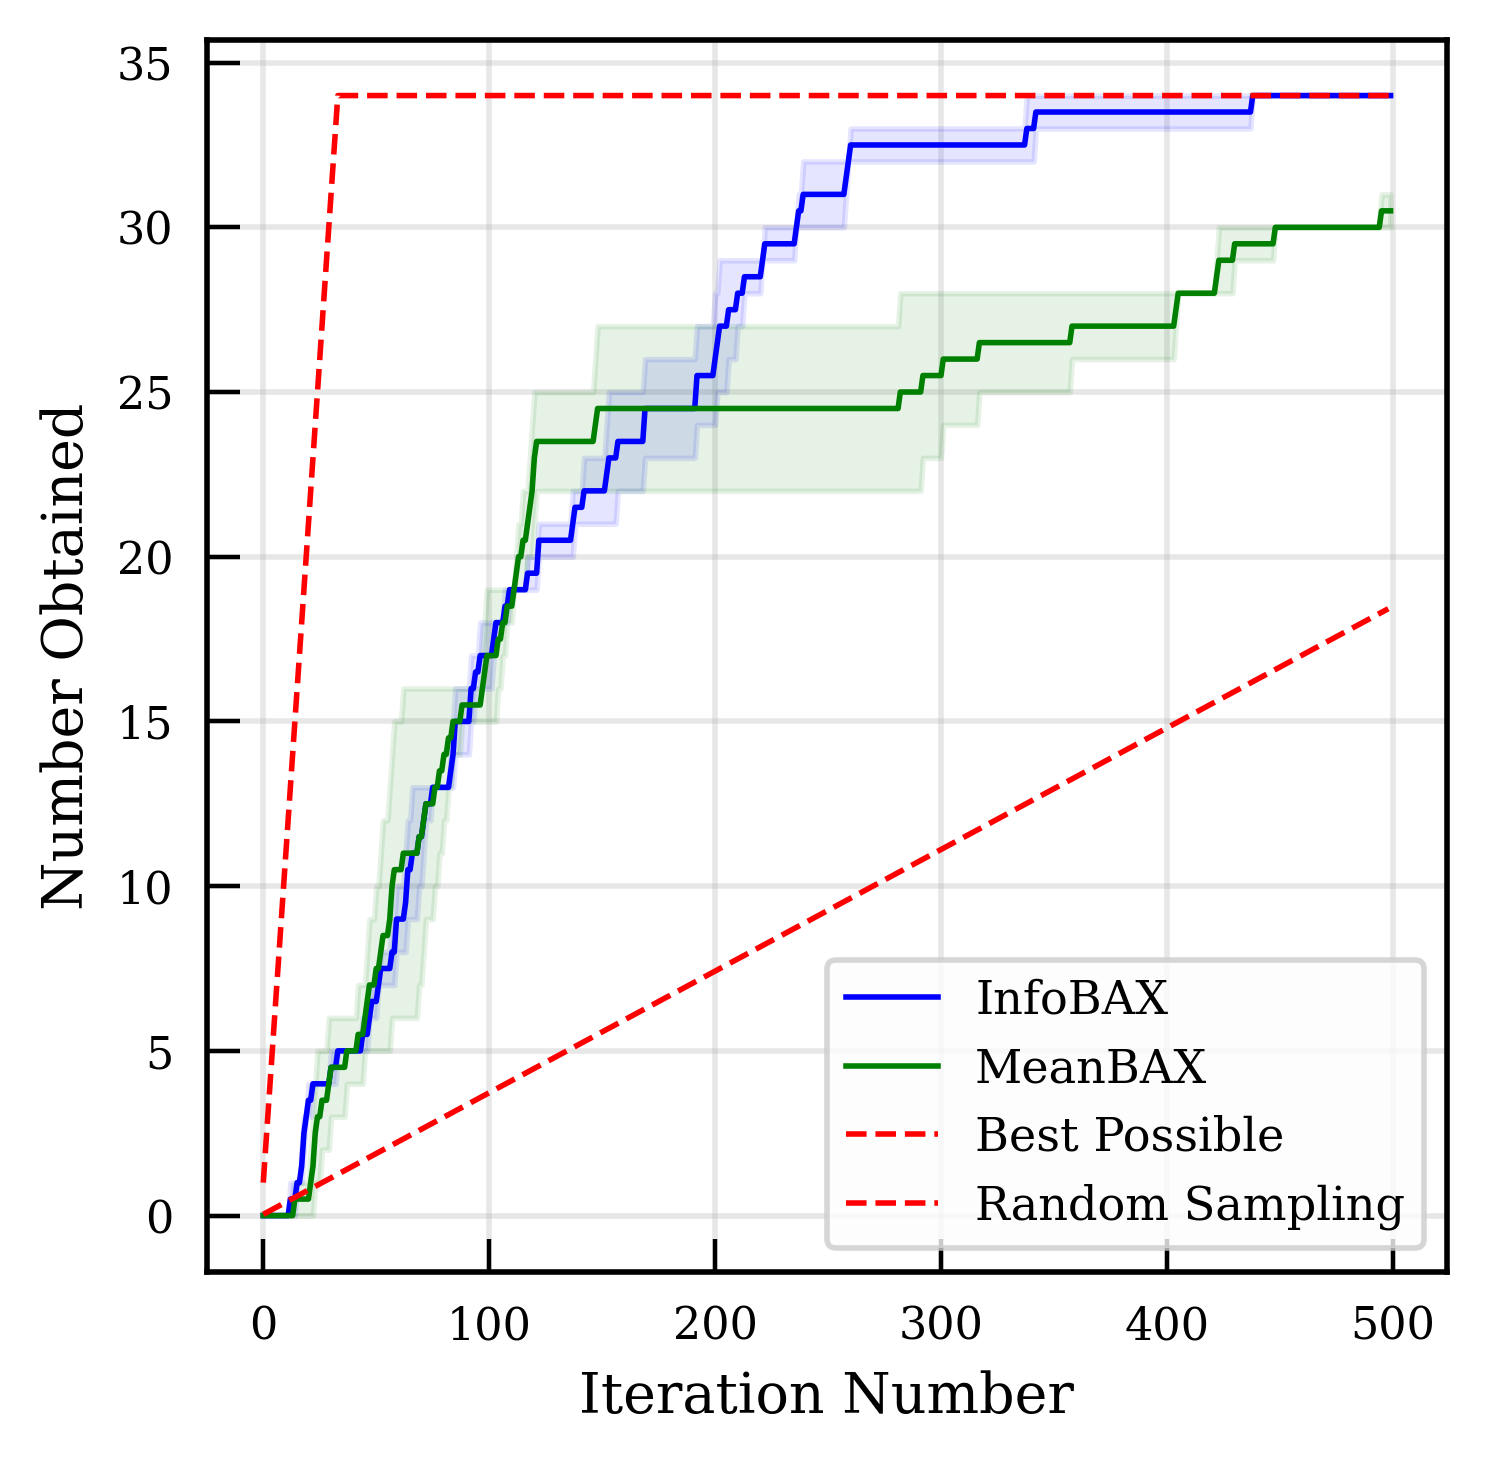

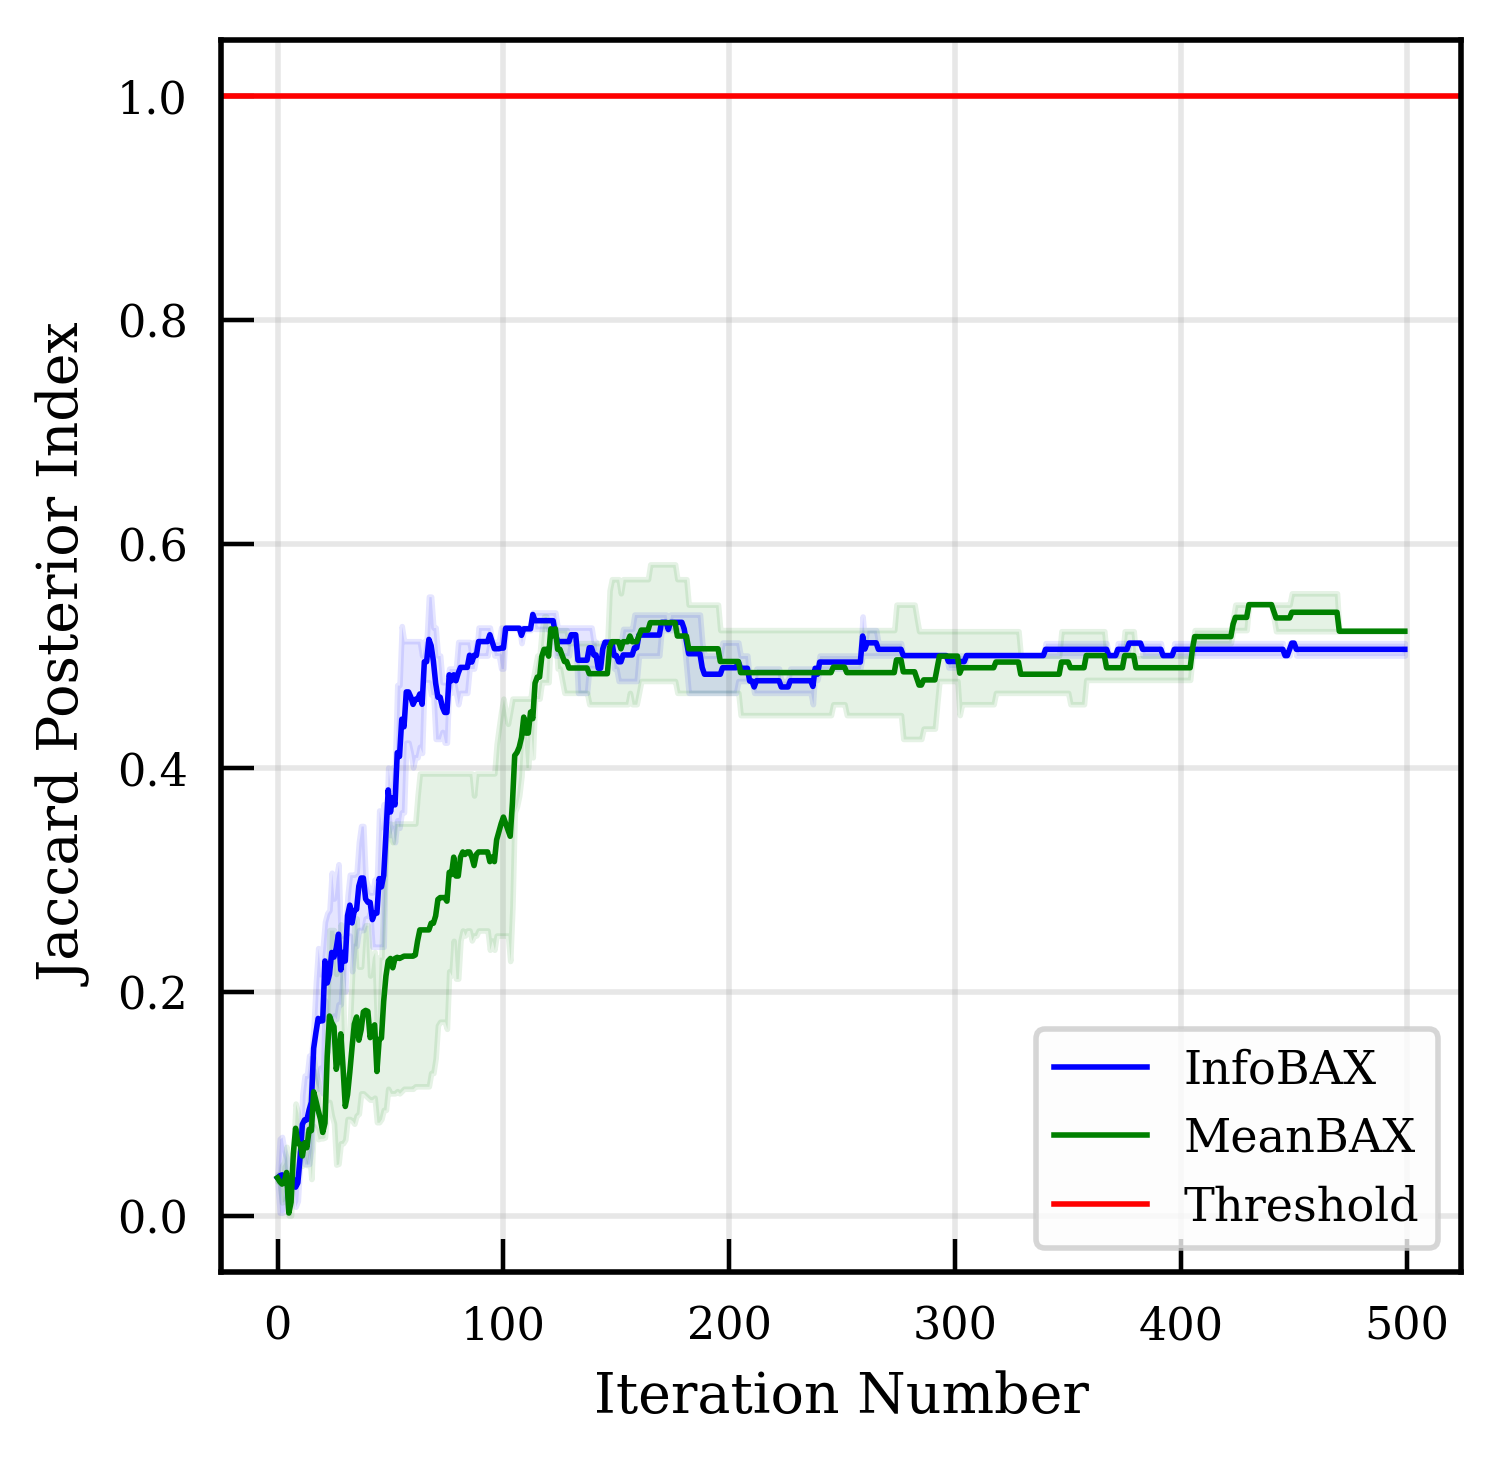

In [14]:
plt.plot(range(n_iters), np.mean(metrics['infobax']['n_obtained'], axis=0), c = 'b', label = 'InfoBAX')
plt.fill_between(range(n_iters), np.mean(metrics['infobax']['n_obtained'], axis=0) - np.std(metrics['infobax']['n_obtained'], axis=0), np.mean(metrics['infobax']['n_obtained'], axis=0) +  np.std(metrics['infobax']['n_obtained'], axis=0),  alpha=0.1, color = 'b')
plt.plot(range(n_iters), np.mean(metrics['meanbax']['n_obtained'], axis=0), c = 'g', label = 'MeanBAX')
plt.fill_between(range(n_iters), np.mean(metrics['meanbax']['n_obtained'], axis=0) - np.std(metrics['meanbax']['n_obtained'], axis=0), np.mean(metrics['meanbax']['n_obtained'], axis=0) + np.std(metrics['meanbax']['n_obtained'], axis=0),  alpha=0.1, color = 'g')
plt.plot(best_possible_n_obtained, 'r--', label='Best Possible')
plt.plot(random_sampling, 'r--', label='Random Sampling')
plt.xlabel('Iteration Number')
plt.ylabel('Number Obtained')
plt.legend()
plt.show()

plt.plot(range(n_iters), np.mean(metrics['infobax']['jaccard_posterior_index'], axis=0), c = 'b', label = 'InfoBAX')
plt.fill_between(range(n_iters), np.mean(metrics['infobax']['jaccard_posterior_index'], axis=0) - np.std(metrics['infobax']['jaccard_posterior_index'], axis=0), np.mean(metrics['infobax']['jaccard_posterior_index'], axis=0) +  np.std(metrics['infobax']['jaccard_posterior_index'], axis=0),  alpha=0.1, color = 'b')
plt.plot(range(n_iters), np.mean(metrics['meanbax']['jaccard_posterior_index'], axis=0), c = 'g', label = 'MeanBAX')
plt.fill_between(range(n_iters), np.mean(metrics['meanbax']['jaccard_posterior_index'], axis=0) - np.std(metrics['meanbax']['jaccard_posterior_index'], axis=0), np.mean(metrics['meanbax']['jaccard_posterior_index'], axis=0) + np.std(metrics['meanbax']['jaccard_posterior_index'], axis=0),  alpha=0.1, color = 'g')
plt.axhline(y=1.0, color='r', linestyle='-', label='Threshold')
plt.xlabel('Iteration Number')
plt.ylabel('Jaccard Posterior Index')
plt.legend()
plt.show()

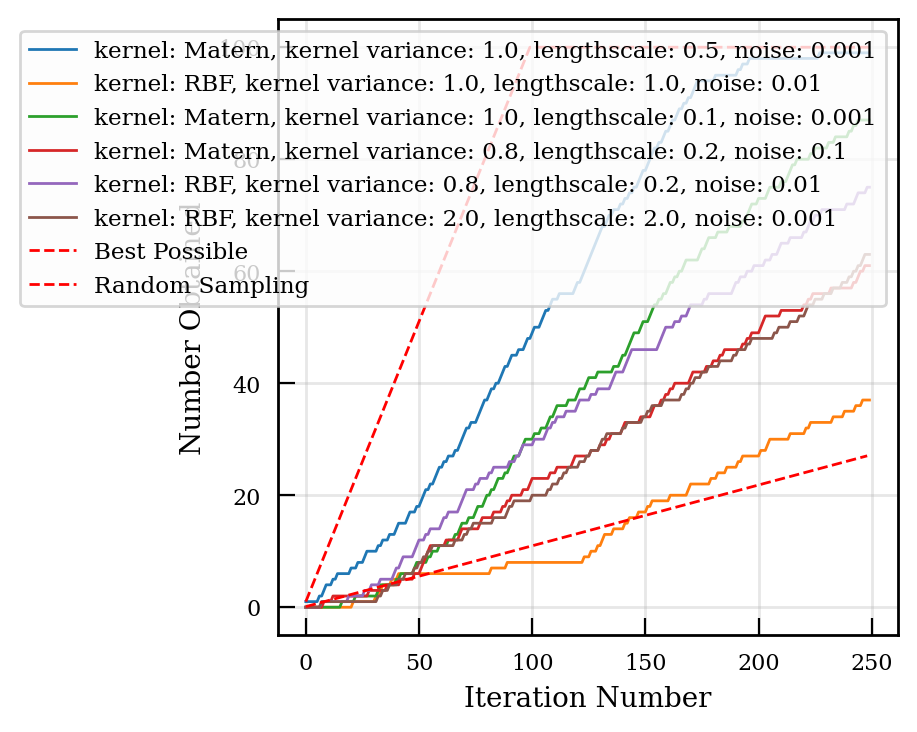

In [60]:
# Plot the first set of data
plt.figure(dpi=200)
for i in range(len(hparams)):
    plt.plot(range(n_iters), metrics['n_obtained'][i], label = "kernel: {}, kernel variance: {}, lengthscale: {}, noise: {}".format(hparams[i][0], hparams[i][1], hparams[i][2], hparams[i][3]))
plt.plot(best_possible_n_obtained, 'r--', label='Best Possible')
plt.plot(random_sampling, 'r--', label='Random Sampling')
plt.xlabel('Iteration Number')
plt.ylabel('Number Obtained')
plt.legend()

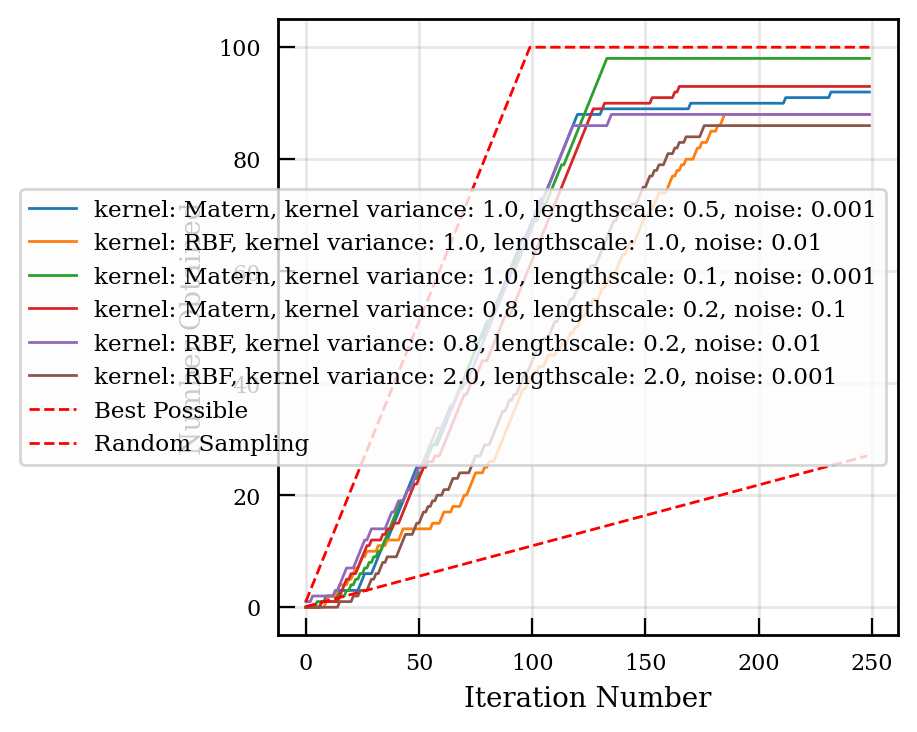

In [58]:
# Plot the first set of data
plt.figure(dpi=200)
for i in range(len(hparams)):
    plt.plot(range(n_iters), metrics['n_obtained'][i], label = "kernel: {}, kernel variance: {}, lengthscale: {}, noise: {}".format(hparams[i][0], hparams[i][1], hparams[i][2], hparams[i][3]))
plt.plot(best_possible_n_obtained, 'r--', label='Best Possible')
plt.plot(random_sampling, 'r--', label='Random Sampling')
plt.xlabel('Iteration Number')
plt.ylabel('Number Obtained')
plt.legend()

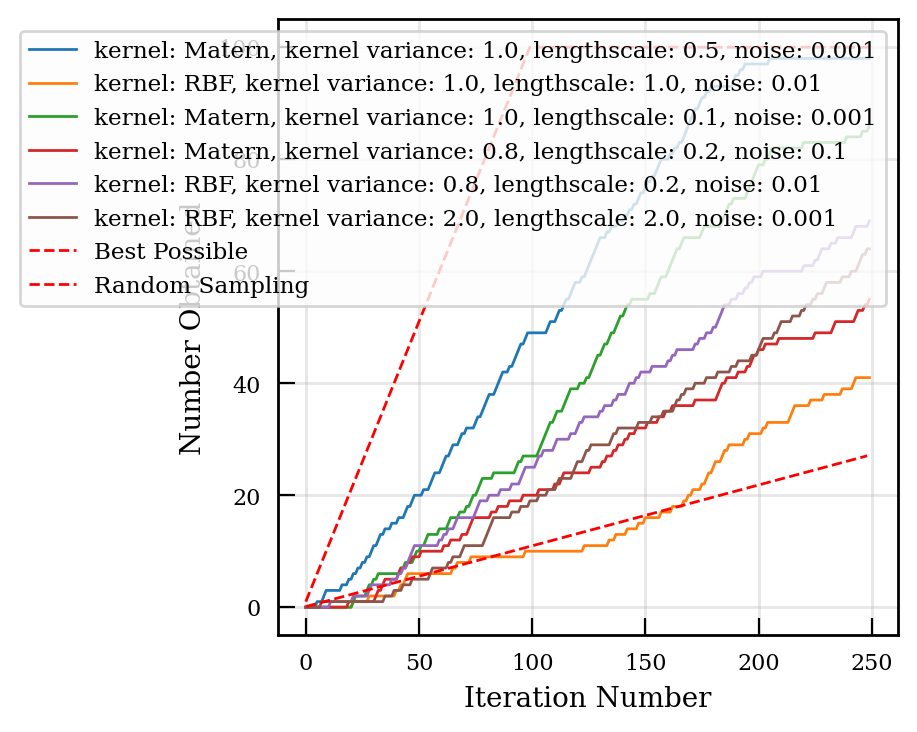

In [55]:
# Plot the first set of data
plt.figure(dpi=200)
for i in range(len(hparams)):
    plt.plot(range(n_iters), metrics['n_obtained'][i], label = "kernel: {}, kernel variance: {}, lengthscale: {}, noise: {}".format(hparams[i][0], hparams[i][1], hparams[i][2], hparams[i][3]))
plt.plot(best_possible_n_obtained, 'r--', label='Best Possible')
plt.plot(random_sampling, 'r--', label='Random Sampling')
plt.xlabel('Iteration Number')
plt.ylabel('Number Obtained')
plt.legend()

In [51]:
from tqdm import tqdm 

metrics = {"n_obtained": [], 
           "jaccard_posterior_index": []}

all_ids = list(np.arange(0, len(X)))
true_target_ids = algorithm.identify_subspace(x=X, y=Y)
true_not_target_ids = list(set(all_ids) - set(true_target_ids))

plotting = False
prevent_requery = True 
plot_frequency = 10
n_posterior_samples = 20
n_initial = 1 
n_iters = 250
n_repeats = 10

# kernel_list = [k, k]

n_posterior_samples_list = [1, 5, 10, 100]

for j in range(len(n_posterior_samples_list)):
    np.random.seed(5)
    n_posterior_samples = n_posterior_samples_list[j]
    k = ConstantKernel(constant_value = 1.0, constant_value_bounds='fixed') * Matern(length_scale=0.5, length_scale_bounds='fixed') + WhiteKernel(0.001, noise_level_bounds='fixed')
    kernel_list = [k, k]

    train_indices = list(np.random.choice(all_ids, n_initial))
    print(train_indices)
    x_train = X[train_indices]
    y_train = Y[train_indices]
    n_features = X.shape[1]

    assert len(kernel_list) == y_train.shape[1]

    collected_ids = list(train_indices)
    n_obtained = [] 
    jaccard_posterior = [] 

    # baselines 
    random_sampling = [random_sampling_no_replace(len(X), len(true_target_ids), n) for n in range(n_initial, n_iters)]

    if n_iters <= len(true_target_ids):
        best_possible_n_obtained = np.arange(n_initial, n_iters + n_initial)
    else:
        best_possible_n_obtained = list(np.arange(n_initial,len(true_target_ids))) + list(len(true_target_ids)*np.ones(n_iters + n_initial - len(true_target_ids)))

    for i in tqdm(range(n_iters)):
        multi_gpr = MGPR(kernel_list=kernel_list)
        acquisition_function, multi_gpr, term1, term2 = multiproperty_infobax(x_domain = X, x_train = x_train, y_train = y_train, model = multi_gpr, algorithm = algorithm, n_posterior_samples=n_posterior_samples, verbose=False)

        vmax = np.max([np.max(term1), np.max(term2)])
        vmin = np.min([np.min(term1), np.min(term2)])
        
        next_id = get_next_id(acquisition_function=acquisition_function, collected_ids=collected_ids, prevent_requery=True)

        collected_ids.append(next_id)
        n_obtained.append(len(set(collected_ids).intersection(set(true_target_ids))))

        posterior_mean, posterior_std = multi_gpr.predict(X)
        predicted_target_ids = algorithm.identify_subspace(x=X, y=posterior_mean)

        jaccard = len(set(predicted_target_ids).intersection(set(true_target_ids)))/len(set(predicted_target_ids).union(set(true_target_ids)))
        jaccard_posterior.append(jaccard)

        if (i % plot_frequency == 0) and (plotting):
            fig, axes = plt.subplots(4, 3, dpi=100, figsize=(18, 24))
            axes[0,0].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
            axes[0,0].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
            axes[0,0].set_xlabel('Targets in design space')

            axes[0,1].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
            axes[0,1].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
            axes[0,1].scatter(X[collected_ids, 0], X[collected_ids, 1], color='red', edgecolor='k')
            axes[0,1].scatter(X[collected_ids, 0][-1], X[collected_ids, 1][-1], color='purple', edgecolor='k')
            axes[0,1].set_xlabel('Collected data (design space)')

            axes[0,2].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.3)
            axes[0,2].scatter(X[true_target_ids, 0], X[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
            axes[0,2].scatter(X[predicted_target_ids, 0], X[predicted_target_ids, 1], color='maroon', marker = 'x')
            axes[0,2].set_xlabel('Posterior mean predicted targets (design space)')

            if Y.shape[1] > 1:
                Y_norm = y_scaler.inverse_transform(Y)
                axes[1,0].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
                axes[1,0].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
                axes[1,0].set_xlabel('Targets in measured property space')
        
                axes[1,1].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
                axes[1,1].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
                axes[1,1].scatter(Y_norm[collected_ids, 0], Y_norm[collected_ids, 1], color='red', edgecolor='k')
                axes[1,1].scatter(Y_norm[collected_ids, 0][-1], Y_norm[collected_ids, 1][-1], color='purple', edgecolor='k')
                axes[1,1].set_xlabel('Sampling in measured property space')

                axes[1,2].scatter(Y_norm[:, 0], Y_norm[:, 1], color='blue', alpha=0.1)
                axes[1,2].scatter(Y_norm[true_target_ids, 0], Y_norm[true_target_ids, 1], color='orange', marker='D', edgecolor='k')
                axes[1,2].scatter(Y_norm[predicted_target_ids, 0], Y_norm[predicted_target_ids, 1], color='maroon', marker ='x')
                axes[1,2].set_xlabel('Posterior mean predicted targets (measured property space)')
            else:
                pass


            axes[2,0].scatter(X[:, 0], X[:, 1], c=acquisition_function)
            axes[2,0].set_xlabel('Acquisition Function')

            t1 = axes[2,1].scatter(X[:, 0], X[:, 1], c=term1, vmin=vmin, vmax=vmax)
            axes[2,1].set_xlabel('Term1')
            fig.colorbar(t1, ax=axes[2,1])

            t2 = axes[2,2].scatter(X[:, 0], X[:, 1], c=term2, vmin=vmin, vmax=vmax)
            axes[2,2].set_xlabel('Term2')
            fig.colorbar(t2, ax=axes[2,2])

            try:
                axes[3,0].plot(np.arange(0, len(n_obtained)), n_obtained, color='k')
                axes[3,0].plot(best_possible_n_obtained, color='r')
                axes[3,0].plot(random_sampling, color='r')
                axes[3,0].set_xlabel('Iteration Number')
                axes[3,0].set_ylabel('Number Obtained')
                axes[3,0].set_ylim(0, 1.1 * len(true_target_ids))
                axes[3,0].set_xlim(0, len(collected_ids) + 5)
            except:
                pass
            
            try:
                axes[3,1].axhline(y=1.0, color='r', linestyle='-')
                axes[3,1].plot(np.arange(0, len(jaccard_posterior)), jaccard_posterior, color='k')
                axes[3,1].set_xlabel('Iteration Number')
                axes[3,1].set_ylabel('Jaccard Posterior Index')
            except:
                pass
            plt.show()


        x_next = X[next_id]
        y_next = Y[next_id]

        x_train = np.vstack((x_train, x_next))
        y_train = np.vstack((y_train, y_next))

    metrics['n_obtained'].append(n_obtained)
    metrics['jaccard_posterior_index'].append(jaccard_posterior)


[867]


100%|██████████| 250/250 [02:49<00:00,  1.47it/s]


[867]


100%|██████████| 250/250 [03:32<00:00,  1.17it/s]


[867]


100%|██████████| 250/250 [04:32<00:00,  1.09s/it]


[867]


100%|██████████| 250/250 [15:27<00:00,  3.71s/it]


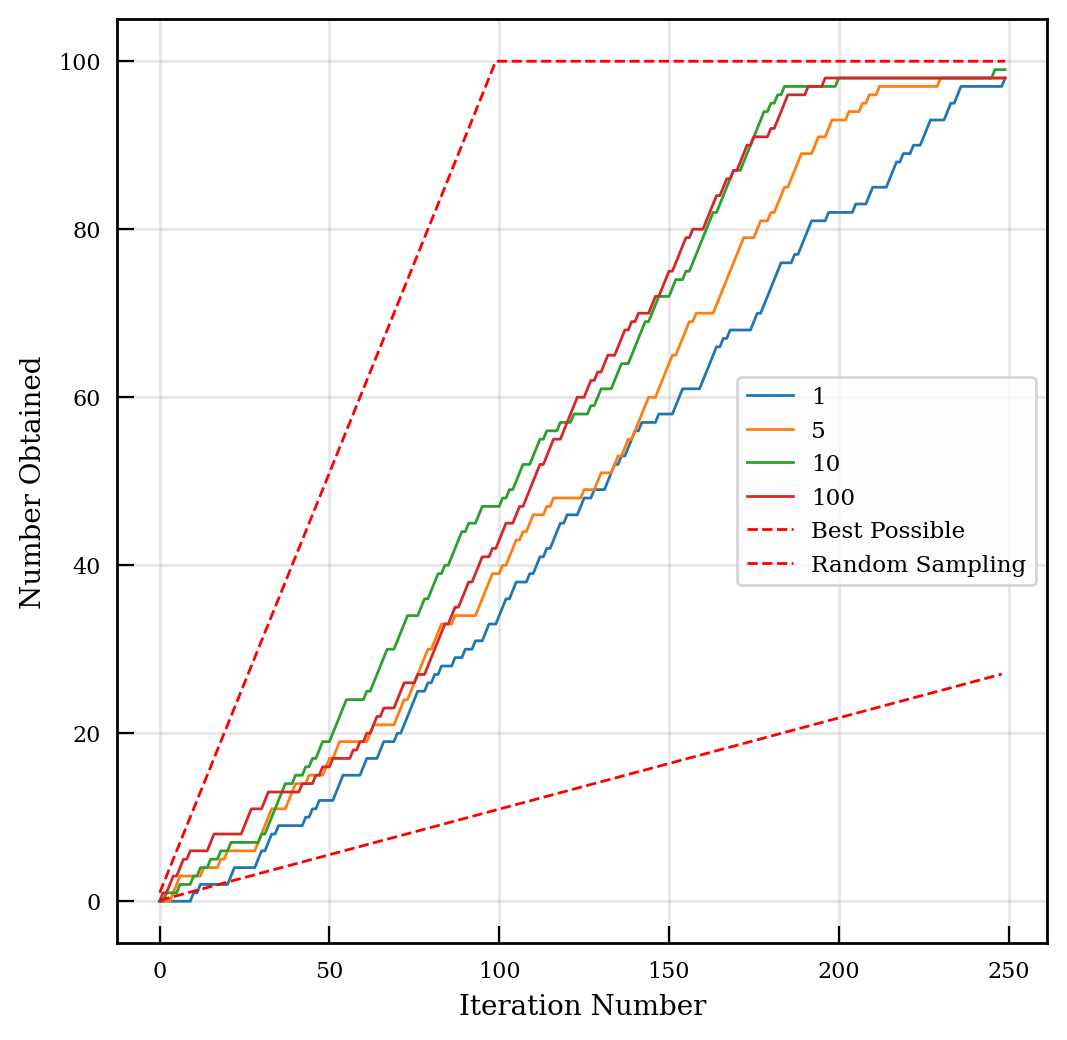

In [52]:
# Plot the first set of data
plt.figure(figsize=(6, 6), dpi=200)
for i in range(len(n_posterior_samples_list)):
    plt.plot(range(n_iters), metrics['n_obtained'][i], label = n_posterior_samples_list[i])
plt.plot(best_possible_n_obtained, 'r--', label='Best Possible')
plt.plot(random_sampling, 'r--', label='Random Sampling')
plt.xlabel('Iteration Number')
plt.ylabel('Number Obtained')
plt.legend()

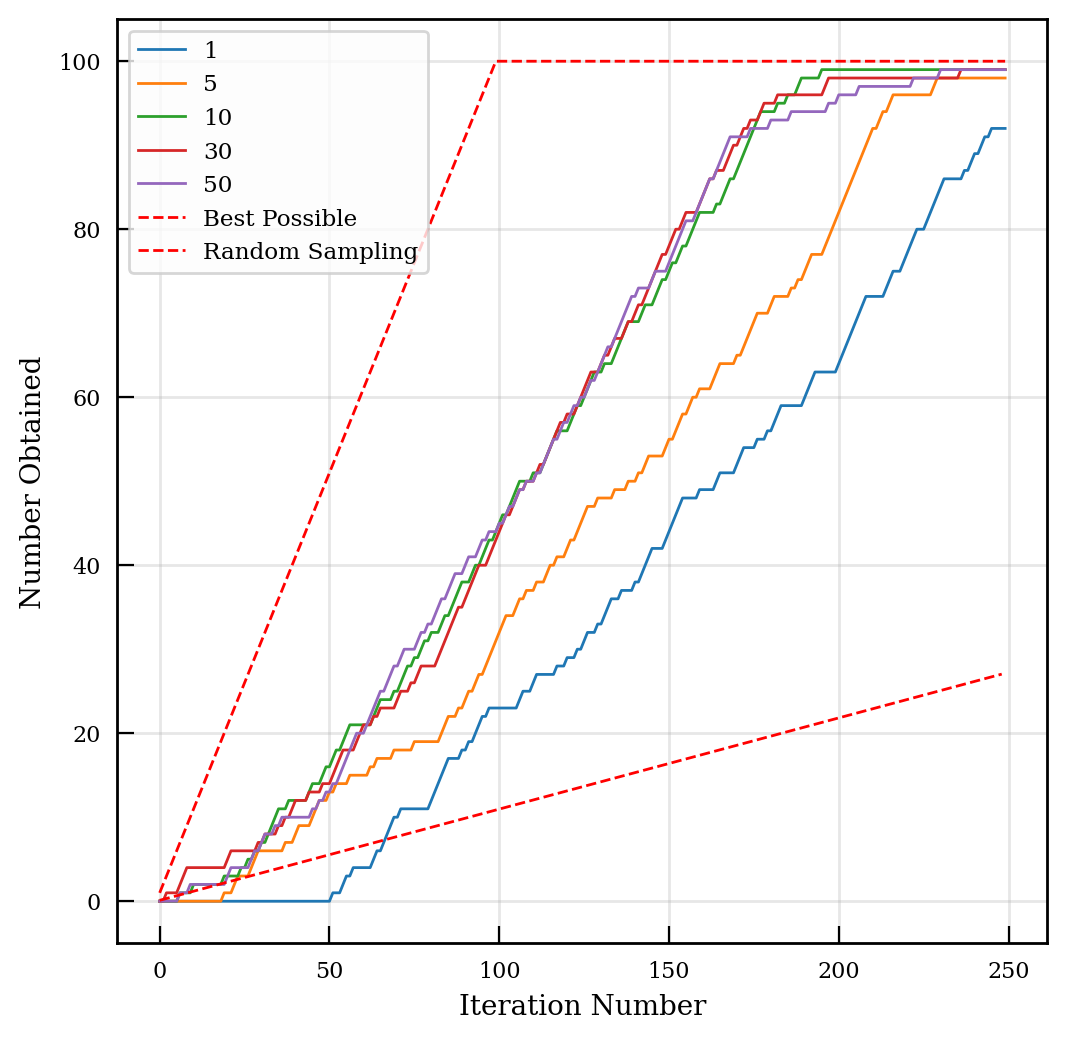

In [48]:
# Plot the first set of data
plt.figure(figsize=(6, 6), dpi=200)
for i in range(len(n_posterior_samples_list)):
    plt.plot(range(n_iters), metrics['n_obtained'][i], label = n_posterior_samples_list[i])
plt.plot(best_possible_n_obtained, 'r--', label='Best Possible')
plt.plot(random_sampling, 'r--', label='Random Sampling')
plt.xlabel('Iteration Number')
plt.ylabel('Number Obtained')
plt.legend()